Задача на звук. Ушел на каггл, так как мой пека умер

Звуковую волну представляют в виде МЕЛ-спектрограммы. Т.е берется *гипер-параметр* - размер окон. Делим волну на пересекающиеся окна. Для каждого окна проходим оконноым преобразованием Фурье и получаем спектрограмму. По оси X - время, по Y - частотный диапазон. Как я понял, чем больше значение, тем больше волн такой длины в исходном окне. Мел пространство - пространство, в котором преобладают частоты, который слишит человек. Поэтому лучше учить модель на таких фичах.

Особо не вникал, https://www.youtube.com/watch?v=fodf4Pttve4.

Т.е из звука получаем данные **[time, mel_count]** - аналогия с текстом - номер слова в тексте и его эмбеддинг. Так что можно как свертками искать фичи, так и рекурренткой

Хз кто придумал давать эту задачу в контесте на 5 часов. Я сдох, пока выбивал 98% акьюраси на скрытом тесте без инфы о скоре на попытках

Сначала делал на обычных данных с помощью сверточной сети. Потом добавил аугментации. Затем заменил свертку на рекуррентку и прошел

In [1]:
!pip install -q timit-utils==0.9.0 tqdm torchaudio librosa

In [3]:
import timit_utils as tu
import os
import librosa
import numpy as np
import tqdm

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import IPython
import pandas as pd


import torchaudio
amplitudes, sr = torchaudio.load('/kaggle/input/speech-gender/train/train/000ad36ce0dcbc1032a606312d5e787d.wav')
# ref2 = torchaudio.transforms.MelSpectrogram(sample_rate=16000, f_min=1, n_mels=128, f_max=8192)(amplitudes)
amplitudes, index = librosa.effects.trim(amplitudes, top_db=20)

annotations = pd.read_csv('/kaggle/input/speech-gender/train/train/targets.tsv', names = ['name', 'label'], sep='\t')

In [6]:
annotations

,name,label
0,5d1f7e43366513a1d0a6ec5640c3dc24,1
1,9a701a4536a05b6610a590a9fe702ed8,1
2,cad0b8547008d1524c1a0e5fd51f9908,1
3,4bbe607e7dc95460e2cc1a6ee5f4dfa6,0
4,30fb32cba90b34af26f3f14f5d636805,0
...,...,...
13931,215443bcce2003d58d7dc6cd53af73ed,1
13932,d26e5ebee3589530a4ec735ba1baab83,0
13933,b9ae9428d4d7d279068aea06365d5736,1
13934,3da22010bcdd5b47d7f2d3ceea190195,0


<Axes: >

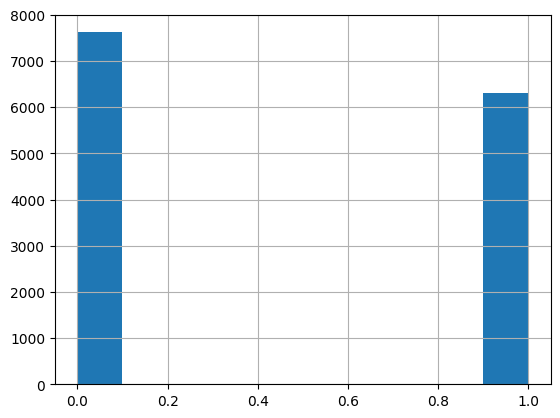

In [5]:
annotations['label'].hist()

Дисбаланса в классах нет

1 версия датасета без аугментаций

In [111]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
class Sound(Dataset):
    def __init__(self, 
                 mode,  
                 sound_dir,
                 annotations,
                 fraction: float = 0.8
                ):
        
        self._mode = mode
        annotations = annotations.sample(frac=1)
        self.sound_dir = sound_dir
        self.annotations = annotations
        
        ## list of tuples: (sound, label) 
        self._items = [] 

        # list of file names
        # list_sound_dir = sorted(os.listdir(sound_dir))
        # self.list_sound_dir = list_sound_dir
        if mode != 'test':
            for _, line in annotations.iterrows():
                self._items.append((line['name'], line['label']))
        else:
            for line in sorted(os.listdir(sound_dir)):
                self._items.append(line)
            
        if mode == 'train':
            self._items = self._items[:int(fraction * len(self._items))]
            
        elif mode == 'val':
            self._items = self._items[int(fraction * len(self._items)):]        
              
        

    def __len__(self):
        return len(self._items)

    def __getitem__(self, index):
        if (self._mode == 'test'):
            sound_name = self._items[index]  
            sound_path = os.path.join(self.sound_dir, sound_name)
            amplitudes, sr = torchaudio.load(sound_path)
            amplitudes, index = librosa.effects.trim(amplitudes, top_db=20)
            spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, f_min=1, n_mels=128, f_max=8192)(amplitudes)[0, :, :MAX_LENGTH]
            spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, MAX_LENGTH - spectrogram.shape[1])]], mode='constant')
            spectrogram = np.array([spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])
            return torch.tensor(spectrogram, dtype=torch.float).to(device), sound_name
            
        sound_name, label = self._items[index]    
        sound_path = os.path.join(self.sound_dir, sound_name + '.wav')
        amplitudes, sr = torchaudio.load(sound_path)
        amplitudes, index = librosa.effects.trim(amplitudes, top_db=20)
        spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, f_min=1, n_mels=128, f_max=8192)(amplitudes)[0, :, :MAX_LENGTH]
        spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, MAX_LENGTH - spectrogram.shape[1])]], mode='constant')
        spectrogram = np.array([spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])
        
        return torch.tensor(spectrogram, dtype=torch.float).to(device), label
    
    
def spec_to_image(spec, eps=1e-6):
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

В ходе страданий попробовал сделать аугментации, поэтому перепишу класс

In [98]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#https://github.com/musikalkemist/audioDataAugmentationTutorial/blob/5365f6a2b22ba8963d10ac80c013d704140b8334/3/dataaugmentation.py#L33
def add_white_noise(noise_percentage_factor):
    def f(signal):
        noise = np.random.normal(0, signal.std(), signal.shape)
        augmented_signal = signal + noise * noise_percentage_factor
        return augmented_signal
    
    return f


def time_stretch(time_stretch_rate):
    """Time stretching implemented with librosa:
    https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift
    """
    def f(signal):        
        return librosa.effects.time_stretch(signal, rate=time_stretch_rate)
    
    return f


# def pitch_scale(signal, sr, num_semitones):
#     """Pitch scaling implemented with librosa:
#     https://librosa.org/doc/main/generated/librosa.effects.pitch_shift.html?highlight=pitch%20shift#librosa.effects.pitch_shift
#     """
#     return librosa.effects.pitch_shift(signal, sr, num_semitones)


def random_gain(signal, min_factor=0.1, max_factor=0.12):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal


def invert_polarity(signal):
    return signal * -1

class Sound(Dataset):
    def __init__(self, 
                 mode,  
                 sound_dir,
                 annotations,
                 fraction: float = 0.8
                ):
        
        self._mode = mode
        annotations = annotations.sample(frac=1)
        self.sound_dir = sound_dir
        if mode == 'train':
            self.annotations = annotations.iloc[:int(fraction * len(annotations))]
        elif mode == 'val':
            self.annotations = annotations.iloc[int(fraction * len(annotations)):]
        
        self.transforms = [invert_polarity, random_gain, add_white_noise(0.5), add_white_noise(0.1), 
                          time_stretch(1.2), time_stretch(0.8)]
        
        ## list of tuples: (sound, label, mask_idx) 
        self._items = [] 

        # list of file names
        # list_sound_dir = sorted(os.listdir(sound_dir))
        # self.list_sound_dir = list_sound_dir
        if mode != 'test':
            for _, line in tqdm.tqdm_notebook(self.annotations.iterrows(), total = len(self.annotations)):
                sound_path = os.path.join(self.sound_dir, line['name'] + '.wav')
                amplitudes, sr = torchaudio.load(sound_path)
                amplitudes, index = librosa.effects.trim(amplitudes, top_db=20) # убирает тишину
                amplitudes = amplitudes.detach().cpu().numpy()
                for aug in self.transforms:
                    new_amplitudes = aug(np.array(amplitudes))  
                    new_amplitudes = torch.tensor(new_amplitudes, dtype=torch.float)
                    spectrogram = torchaudio.transforms.MelSpectrogram(
                        sample_rate=sr, f_min=1, n_mels=128, f_max=8192)(new_amplitudes)[0, :, :MAX_LENGTH]
                    mask_end_idx = spectrogram.shape[1]
                    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, MAX_LENGTH - 
                                                                       spectrogram.shape[1])]], mode='constant')
#                     spectrogram = np.array([spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])
                    self._items.append((torch.tensor(spectrogram, dtype=torch.float).to(device), 
                                        line['label'], mask_end_idx - 1))
        else:
            for line in sorted(os.listdir(sound_dir)):
                self._items.append(line)         
              
        

    def __len__(self):
        return len(self._items)

    def __getitem__(self, index):
        if (self._mode == 'test'):
            sound_name = self._items[index]  
            sound_path = os.path.join(self.sound_dir, sound_name)
            amplitudes, sr = torchaudio.load(sound_path)
            amplitudes, index = librosa.effects.trim(amplitudes, top_db=20)
            spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sr, f_min=1, n_mels=128,
                                                               f_max=8192)(amplitudes)[0, :, :MAX_LENGTH]
            mask_end_idx = spectrogram.shape[1]
            spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, MAX_LENGTH - spectrogram.shape[1])]], mode='constant')
#             spectrogram = np.array([spec_to_image(np.float32(spectrogram))]).transpose([0, 2, 1])
            return torch.tensor(spectrogram, dtype=torch.float).to(device),sound_name, torch.tensor(mask_end_idx - 1).to(device)
            
        spectrogram, label, mask_end_idx = self._items[index]            
        return torch.tensor(spectrogram, dtype=torch.float).to(device), \
    torch.tensor(label).to(device), torch.tensor(mask_end_idx).to(device)

Возьму сверточную модельку. Архитектура не моя, взял у умных ребят из МФТИ: https://www.youtube.com/watch?v=fodf4Pttve4&t=1028s

In [12]:
class Model(nn.Module):
    def __init__(self, window_sizes=(2, 3, 4, 5)):
        super(Model, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv2d(1, 128, [window_size, 128], padding=(window_size - 1, 0))
            for window_size in window_sizes
        ])

        self.fc = nn.Linear(128 * len(window_sizes), 2)

    def forward(self, x):
        # Apply a convolution + max pool layer for each window size
        # x = torch.unsqueeze(x, 1)  # [B, C, T, E] Add a channel dim.
        xs = []
        for conv in self.convs:
            x2 = F.relu(conv(x))  # [B, F, T, 1]
            x2 = torch.squeeze(x2, -1)  # [B, F, T]
            x2 = F.max_pool1d(x2, x2.size(2))  # [B, F, 1]
            xs.append(x2)
        x = torch.cat(xs, 2)  # [B, F, window]

        # FC
        x = x.view(x.size(0), -1)  # [B, F * window]
        logits = self.fc(x)  # [B, class]
        probs = F.log_softmax(logits, dim=1)
        return probs

    def loss(self, logits, targets):
        return F.nll_loss(logits, targets)

Однако 0.995 на валидации + аугментации не помогли пройти тест))

In [24]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

230914

Поэтому вот уже моя моделька с реккуренткой ЛСТМ

In [85]:
class ModelRNN(nn.Module):
    def __init__(self, hid_size = 128, bidirectional=True, num_layers=2, batch_size=64):
        super(ModelRNN, self).__init__()
        
        self.D = 2 if bidirectional == True else 1
        self.bidirectional = bidirectional
        self.hid_size = hid_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.rnn = nn.LSTM(input_size=128, hidden_size =hid_size, num_layers=num_layers,
              bidirectional = bidirectional, batch_first=True)
        
        self.fc1 = nn.Linear(self.D * hid_size, int((self.D * hid_size)/2))
        self.fc2 = nn.Linear(int((self.D * hid_size)/2), 2)
#         self.batch_norm = nn.BatchNorm1d(hid_size)
        self.drop = nn.Dropout1d(p=0.3)
        
        self.relu = nn.ReLU()

    def forward(self, x, mask_idx):
        h0 = torch.randn(self.D * self.num_layers, self.batch_size, self.hid_size).to(device) # D*numlayers, batch_size, hid_size
        c0 = torch.randn(self.D * self.num_layers, self.batch_size, self.hid_size).to(device) # D*numlayers, batch_size, hid_size
#         print(x.shape, mask_idx)
        output, (_, _) = self.rnn(x.permute(0,2,1), (h0, c0))
#         print(output.shape)
#         return output
        
        x = self.fc1(output[torch.arange(output.size(0)), mask_idx, :])
#         print(x.shape)
#         x = self.drop(x)
#         print(x.shape)
        x = self.relu(x)
#         print(x.shape)
        x = self.fc2(x)
#         print(x.shape)
        
        return F.log_softmax(x, dim=1)
        

    def loss(self, logits, targets):
        return F.nll_loss(logits, targets)

In [86]:
model2 = ModelRNN(hid_size = 128, bidirectional=True, num_layers=1, batch_size=64)
sum([p.numel() for p in model2.parameters() if p.requires_grad])

297346

Это цикл обучения для первой модели

In [14]:
import random
MAX_LENGTH = 150
device='cuda'
BATCH_SIZE = 64
NUM_EPOCHS = 10
dataset_train = Sound('train', '/kaggle/input/speech-gender/train/train', annotations, fraction=0.85)
dataset_val = Sound('val', '/kaggle/input/speech-gender/train/train', annotations, fraction=0.85)
train_loader = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=BATCH_SIZE, shuffle=True)
model = Model().to(device)
# model.load_state_dict(last_good_model)
# model.load_state_dict(torch.load('try1/model.pth'))
last_good_model = model.state_dict()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)
best_acc = 0

accuracy_history = []
loss_history = []
for epoch in tqdm.trange(NUM_EPOCHS):
    for batch_data, batch_labels in tqdm.tqdm_notebook(train_loader):

        if len(loss_history) % 92 == 0:
            model.eval()
            accs = []
            for batch_data2, batch_labels2 in tqdm.tqdm_notebook(val_loader):
                with torch.no_grad():
                    logits = model(batch_data2.to(device))
                batch_labels2 = batch_labels2.to(device)
                acc = torch.sum(logits.argmax(dim=1) == batch_labels2) / batch_labels2.shape[0]
                accs.append(acc.item())

            accuracy_history.append(np.mean(accs))
            print(accuracy_history[-1])
            if (len(accuracy_history) > 1 and accuracy_history[-1] > best_acc):
                last_good_model = model.state_dict()
                best_acc = accuracy_history[-1]

        model.train()
        optimizer.zero_grad()
        logits = model(batch_data)
        loss = model.loss(logits.to(device), batch_labels.to(device))
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())


            
            
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item()}')
    

/tmp/ipykernel_28/2105287196.py:63: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, line in tqdm.tqdm_notebook(annotations.iterrows(), total = len(annotations) * len(self.transforms)):


  0%|          | 0/83616 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/tmp/ipykernel_28/2105287196.py:63: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, line in tqdm.tqdm_notebook(ann

  0%|          | 0/83616 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_28/3503880223.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_data, batch_labels in tqdm.tqdm_notebook(train_loader):


  0%|          | 0/1111 [00:00<?, ?it/s]

/tmp/ipykernel_28/3503880223.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_data2, batch_labels2 in tqdm.tqdm_notebook(val_loader):


  0%|          | 0/196 [00:00<?, ?it/s]

0.3436943230276205


  0%|          | 0/196 [00:00<?, ?it/s]

0.8864707344648789


  0%|          | 0/196 [00:00<?, ?it/s]

0.8603961677575598


  0%|          | 0/196 [00:00<?, ?it/s]

0.9066372088023594


  0%|          | 0/196 [00:00<?, ?it/s]

0.93773409693825


  0%|          | 0/196 [00:00<?, ?it/s]

0.9504044180621907


  0%|          | 0/196 [00:00<?, ?it/s]

0.9410810458416842


  0%|          | 0/196 [00:00<?, ?it/s]

0.9616511786470607


  0%|          | 0/196 [00:00<?, ?it/s]

0.9485797298197843


  0%|          | 0/196 [00:00<?, ?it/s]

0.8897404947451183


  0%|          | 0/196 [00:00<?, ?it/s]

0.9531174080104244


  0%|          | 0/196 [00:00<?, ?it/s]

0.9736900715803614


  0%|          | 0/196 [00:00<?, ?it/s]

0.9552748930089328


 10%|█         | 1/10 [01:52<16:55, 112.81s/it]

Epoch [1/10], Loss: 0.05847132205963135


  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9657978521926063


  0%|          | 0/196 [00:00<?, ?it/s]

0.948419025661994


  0%|          | 0/196 [00:00<?, ?it/s]

0.9705012960701572


  0%|          | 0/196 [00:00<?, ?it/s]

0.9763208113762797


  0%|          | 0/196 [00:00<?, ?it/s]

0.9673922399477083


  0%|          | 0/196 [00:00<?, ?it/s]

0.9744885308401925


  0%|          | 0/196 [00:00<?, ?it/s]

0.9778354797436266


  0%|          | 0/196 [00:00<?, ?it/s]

0.9773584287993762


  0%|          | 0/196 [00:00<?, ?it/s]

0.972653719539545


  0%|          | 0/196 [00:00<?, ?it/s]

0.9789528165544782


  0%|          | 0/196 [00:00<?, ?it/s]

0.9701811531368567


  0%|          | 0/196 [00:00<?, ?it/s]

0.9668342042334226


 20%|██        | 2/10 [03:39<14:32, 109.12s/it]

Epoch [2/10], Loss: 0.06190626695752144


  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9708201736211777


  0%|          | 0/196 [00:00<?, ?it/s]

0.9673137859422334


  0%|          | 0/196 [00:00<?, ?it/s]

0.9763208113762797


  0%|          | 0/196 [00:00<?, ?it/s]

0.9819036989795918


  0%|          | 0/196 [00:00<?, ?it/s]

0.9610121581627398


  0%|          | 0/196 [00:00<?, ?it/s]

0.9559898367341684


  0%|          | 0/196 [00:00<?, ?it/s]

0.9520089285714286


  0%|          | 0/196 [00:00<?, ?it/s]

0.9720184948979592


  0%|          | 0/196 [00:00<?, ?it/s]

0.9702634032891722


  0%|          | 0/196 [00:00<?, ?it/s]

0.9800688879830497


  0%|          | 0/196 [00:00<?, ?it/s]

0.9803055153817547


  0%|          | 0/196 [00:00<?, ?it/s]

0.9817417297436266


 30%|███       | 3/10 [05:26<12:36, 108.06s/it]

Epoch [3/10], Loss: 0.08686920255422592


  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9782353420646823


  0%|          | 0/196 [00:00<?, ?it/s]

0.9637251481109735


  0%|          | 0/196 [00:00<?, ?it/s]

0.9791919747177436


  0%|          | 0/196 [00:00<?, ?it/s]

0.9828590665544782


  0%|          | 0/196 [00:00<?, ?it/s]

0.9818999031368567


  0%|          | 0/196 [00:00<?, ?it/s]

0.981500040815801


  0%|          | 0/196 [00:00<?, ?it/s]

0.9811001784947454


  0%|          | 0/196 [00:00<?, ?it/s]

0.9833386479591837


  0%|          | 0/196 [00:00<?, ?it/s]

0.9824617346938775


  0%|          | 0/196 [00:00<?, ?it/s]

0.969859744821276


  0%|          | 0/196 [00:00<?, ?it/s]

0.9710568010198827


  0%|          | 0/196 [00:00<?, ?it/s]

0.9716198979591837


 40%|████      | 4/10 [07:12<10:44, 107.49s/it]

Epoch [4/10], Loss: 0.00335520482622087


  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.985808683901417


  0%|          | 0/196 [00:00<?, ?it/s]

0.9837372448979592


  0%|          | 0/196 [00:00<?, ?it/s]

0.9789528165544782


  0%|          | 0/196 [00:00<?, ?it/s]

0.9837347144375042


  0%|          | 0/196 [00:00<?, ?it/s]

0.9854100869626415


  0%|          | 0/196 [00:00<?, ?it/s]

0.9834183673469388


  0%|          | 0/196 [00:00<?, ?it/s]

0.9597391787232185


  0%|          | 0/196 [00:00<?, ?it/s]

0.9870829287232185


  0%|          | 0/196 [00:00<?, ?it/s]

0.983575275661994


  0%|          | 0/196 [00:00<?, ?it/s]

0.9771192706361109


  0%|          | 0/196 [00:00<?, ?it/s]

0.9827793471667231


  0%|          | 0/196 [00:00<?, ?it/s]

0.9802283267585599


 50%|█████     | 5/10 [08:59<08:56, 107.28s/it]

Epoch [5/10], Loss: 0.0998895913362503


  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9753654441054986


  0%|          | 0/196 [00:00<?, ?it/s]

0.9858884032891722


  0%|          | 0/196 [00:00<?, ?it/s]

0.9819036989795918


  0%|          | 0/196 [00:00<?, ?it/s]

0.9868463010204082


  0%|          | 0/196 [00:00<?, ?it/s]

0.9721741378307343


  0%|          | 0/196 [00:00<?, ?it/s]

0.9767219387755102


  0%|          | 0/196 [00:00<?, ?it/s]

0.9809470663265306


  0%|          | 0/196 [00:00<?, ?it/s]

0.9826211734693877


  0%|          | 0/196 [00:00<?, ?it/s]

0.9861275614524374


  0%|          | 0/196 [00:00<?, ?it/s]

0.9848520512483558


  0%|          | 0/196 [00:00<?, ?it/s]

0.9896352145136619


  0%|          | 0/196 [00:00<?, ?it/s]

0.9865248930089328


 60%|██████    | 6/10 [10:46<07:08, 107.21s/it]

Epoch [6/10], Loss: 0.0015667950501665473


  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9887583012483558


  0%|          | 0/196 [00:00<?, ?it/s]

0.9878029336734694


  0%|          | 0/196 [00:00<?, ?it/s]

0.9772002551020408


  0%|          | 0/196 [00:00<?, ?it/s]

0.9849317706361109


  0%|          | 0/196 [00:00<?, ?it/s]

0.9900338114524374


  0%|          | 0/196 [00:00<?, ?it/s]

0.9862085459183674


  0%|          | 0/196 [00:00<?, ?it/s]

0.9802295918367347


  0%|          | 0/196 [00:00<?, ?it/s]

0.9717768062742389


  0%|          | 0/196 [00:00<?, ?it/s]

0.9870032093354634


  0%|          | 0/196 [00:00<?, ?it/s]

0.9837372448979592


  0%|          | 0/196 [00:00<?, ?it/s]

0.9874840561224489


  0%|          | 0/196 [00:00<?, ?it/s]

0.9844534543095803


 70%|███████   | 7/10 [12:33<05:21, 107.06s/it]

Epoch [7/10], Loss: 0.002016327576711774


  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9856492451259068


  0%|          | 0/196 [00:00<?, ?it/s]

0.985011490023866


  0%|          | 0/196 [00:00<?, ?it/s]

0.9884394236973354


  0%|          | 0/196 [00:00<?, ?it/s]

0.9776773063503966


  0%|          | 0/196 [00:00<?, ?it/s]

0.9893176020408163


  0%|          | 0/196 [00:00<?, ?it/s]

0.9858858725246118


  0%|          | 0/196 [00:00<?, ?it/s]

0.9908322704081632


  0%|          | 0/196 [00:00<?, ?it/s]

0.98445092354502


  0%|          | 0/196 [00:00<?, ?it/s]

0.9787136583912129


  0%|          | 0/196 [00:00<?, ?it/s]

0.9869260204081632


  0%|          | 0/196 [00:00<?, ?it/s]

0.9839764030612245


  0%|          | 0/196 [00:00<?, ?it/s]

0.9771192706361109


 80%|████████  | 8/10 [14:20<03:33, 106.93s/it]

Epoch [8/10], Loss: 0.0034275781363248825


  0%|          | 0/1111 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.987323352268764


  0%|          | 0/196 [00:00<?, ?it/s]

0.9913080562742389


  0%|          | 0/196 [00:00<?, ?it/s]

0.9903539540816326


  0%|          | 0/196 [00:00<?, ?it/s]

0.9900350765306123


 80%|████████  | 8/10 [14:53<03:43, 111.63s/it]


KeyboardInterrupt: 

А это для второй. Пару замечаний:
1. Мне было впадлу вспоминать как пользоваться торчовскими коллбеками, так что я вручную сохранял лучшую модель на валидации `last_good_model`
2. Я решил обойтись без коллейта - падил прям в датасете по гиперпараметру MAX_LENGTH
3. Даталоадер выдает 3 батча - данные, метки и индекс настоящего конца времени, так как хочется брать скрытый слой не после паддингов

In [87]:
import random
import torchaudio
MAX_LENGTH = 150
device='cuda'
BATCH_SIZE = 64
NUM_EPOCHS = 20
dataset_train = Sound('train', '/kaggle/input/speech-gender/train/train', annotations, fraction=0.85)
dataset_val = Sound('val', '/kaggle/input/speech-gender/train/train', annotations, fraction=0.85) #0.85
train_loader = DataLoader(dataset=dataset_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
model = ModelRNN(hid_size = 128, bidirectional=True, num_layers=1, batch_size=BATCH_SIZE).to(device)
# model.load_state_dict(last_good_model)
# model.load_state_dict(torch.load('try1/model.pth'))
last_good_model = model.state_dict()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=5e-4)
best_acc = 0

accuracy_history = []
loss_history = []
for epoch in tqdm.trange(NUM_EPOCHS):
    for batch_data, batch_labels, mask_idxes in tqdm.tqdm_notebook(train_loader): #train_loader

        if len(loss_history) % (6 * 92) == 0:
            model.eval()
            accs = []
            for batch_data2, batch_labels2, mask_idxes2 in tqdm.tqdm_notebook(val_loader):
                with torch.no_grad():
                    logits = model(batch_data2, mask_idxes2)
                acc = torch.sum(logits.argmax(dim=1) == batch_labels2) / batch_labels2.shape[0]
                accs.append(acc.item())

            accuracy_history.append(np.mean(accs))
            print(accuracy_history[-1])
            if (len(accuracy_history) > 1 and accuracy_history[-1] > best_acc):
                last_good_model = model.state_dict()
                best_acc = accuracy_history[-1]

        model.train()
        optimizer.zero_grad()
        logits = model(batch_data, mask_idxes)
        loss = model.loss(logits, batch_labels)
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())


            
            
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item()}')
    

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_29/1424148191.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_data, batch_labels, mask_idxes in tqdm.tqdm_notebook(train_loader): #train_loader


  0%|          | 0/1110 [00:00<?, ?it/s]

/tmp/ipykernel_29/1431059374.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(spectrogram, dtype=torch.float).to(device), \
/tmp/ipykernel_29/1424148191.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_data2, batch_labels2, mask_idxes2 in tqdm.tqdm_notebook(val_loader):


  0%|          | 0/196 [00:00<?, ?it/s]

0.5362723214285714


  0%|          | 0/196 [00:00<?, ?it/s]

0.9436383928571429


  0%|          | 0/196 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:23<07:27, 23.57s/it]

0.9561543367346939
Epoch [1/20], Loss: 0.11853734403848648


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9591836734693877


  0%|          | 0/196 [00:00<?, ?it/s]

 10%|█         | 2/20 [00:45<06:46, 22.58s/it]

0.9620535714285714
Epoch [2/20], Loss: 0.13511314988136292


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9675542091836735


  0%|          | 0/196 [00:00<?, ?it/s]

0.9666772959183674


 15%|█▌        | 3/20 [01:07<06:20, 22.37s/it]

Epoch [3/20], Loss: 0.1180623397231102


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9621332908163265


  0%|          | 0/196 [00:00<?, ?it/s]

0.96484375


 20%|██        | 4/20 [01:29<05:53, 22.11s/it]

Epoch [4/20], Loss: 0.048979319632053375


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9679528061224489


  0%|          | 0/196 [00:00<?, ?it/s]

0.9715401785714286


 25%|██▌       | 5/20 [01:51<05:30, 22.02s/it]

Epoch [5/20], Loss: 0.06397052854299545


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9743303571428571


  0%|          | 0/196 [00:00<?, ?it/s]

0.9702646683673469


 30%|███       | 6/20 [02:13<05:07, 21.97s/it]

Epoch [6/20], Loss: 0.07622740417718887


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9755261479591837


  0%|          | 0/196 [00:00<?, ?it/s]

0.9767219387755102


 35%|███▌      | 7/20 [02:34<04:45, 21.94s/it]

Epoch [7/20], Loss: 0.06964708864688873


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9765625


  0%|          | 0/196 [00:00<?, ?it/s]

0.9768813775510204


 40%|████      | 8/20 [02:56<04:23, 21.94s/it]

Epoch [8/20], Loss: 0.044740259647369385


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9767219387755102


  0%|          | 0/196 [00:00<?, ?it/s]

0.9767219387755102


 45%|████▌     | 9/20 [03:18<04:01, 21.95s/it]

Epoch [9/20], Loss: 0.025079190731048584


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9769610969387755


  0%|          | 0/196 [00:00<?, ?it/s]

0.9801498724489796


 50%|█████     | 10/20 [03:40<03:39, 21.92s/it]

Epoch [10/20], Loss: 0.0675487071275711


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9578284438775511


  0%|          | 0/196 [00:00<?, ?it/s]

0.9769610969387755


 55%|█████▌    | 11/20 [04:02<03:16, 21.80s/it]

Epoch [11/20], Loss: 0.10131274908781052


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9803890306122449


  0%|          | 0/196 [00:00<?, ?it/s]

0.9760044642857143


 60%|██████    | 12/20 [04:24<02:55, 21.88s/it]

Epoch [12/20], Loss: 0.035721611231565475


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9756058673469388


  0%|          | 0/196 [00:00<?, ?it/s]

0.9792729591836735


 65%|██████▌   | 13/20 [04:46<02:33, 21.94s/it]

Epoch [13/20], Loss: 0.04594332352280617


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9790338010204082


  0%|          | 0/196 [00:00<?, ?it/s]

0.9815848214285714


 70%|███████   | 14/20 [05:07<02:10, 21.82s/it]

Epoch [14/20], Loss: 0.03130073845386505


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9805484693877551


  0%|          | 0/196 [00:00<?, ?it/s]

0.9753667091836735


 75%|███████▌  | 15/20 [05:29<01:49, 21.86s/it]

Epoch [15/20], Loss: 0.03375428542494774


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9779974489795918


  0%|          | 0/196 [00:00<?, ?it/s]

0.9823820153061225


 80%|████████  | 16/20 [05:51<01:27, 21.88s/it]

Epoch [16/20], Loss: 0.018387915566563606


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.984375


  0%|          | 0/196 [00:00<?, ?it/s]

0.9852519132653061


 85%|████████▌ | 17/20 [06:13<01:05, 21.79s/it]

Epoch [17/20], Loss: 0.11504698544740677


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9834183673469388


  0%|          | 0/196 [00:00<?, ?it/s]

0.9838966836734694


 90%|█████████ | 18/20 [06:36<00:44, 22.07s/it]

Epoch [18/20], Loss: 0.09886008501052856


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9803093112244898


  0%|          | 0/196 [00:00<?, ?it/s]

0.9833386479591837


 95%|█████████▌| 19/20 [06:58<00:22, 22.06s/it]

Epoch [19/20], Loss: 0.013195419684052467


  0%|          | 0/1110 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

0.9840561224489796


  0%|          | 0/196 [00:00<?, ?it/s]

0.9821428571428571


100%|██████████| 20/20 [07:19<00:00, 21.99s/it]

Epoch [20/20], Loss: 0.01379703450948


In [88]:
best_acc

0.9852519132653061

In [152]:
model.eval()
model.load_state_dict(last_good_model)
accs = []
for batch_data2, batch_labels2 in tqdm.tqdm_notebook(val_loader):
    with torch.no_grad():
        logits = model(batch_data2.to(device))
    batch_labels2 = batch_labels2.to(device)
    acc = torch.sum(logits.argmax(dim=1) == batch_labels2) / batch_labels2.shape[0]
    accs.append(acc.item())

accuracy_history.append(np.mean(accs))
print(accuracy_history[-1])

/tmp/ipykernel_28/1311860084.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_data2, batch_labels2 in tqdm.tqdm_notebook(val_loader):


  0%|          | 0/131 [00:00<?, ?it/s]

0.9861016450947477


In [89]:
torch.save(last_good_model, '/kaggle/working/model.pth')

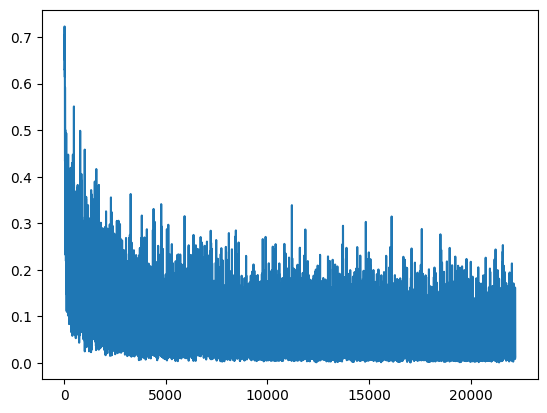

In [90]:
plt.plot(loss_history)

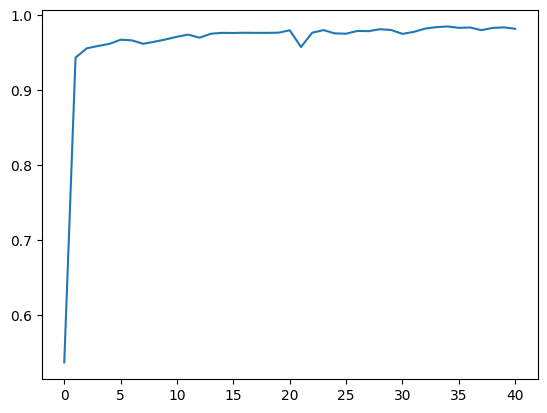

In [91]:
plt.plot(accuracy_history)

In [92]:
out_file = "/kaggle/working/targets.tsv"
f = open(out_file, "w+")

In [100]:
dataset_test = Sound('test', '/kaggle/input/speech-gender/test/test', annotations)
test_loader = DataLoader(dataset=dataset_test, batch_size=1, shuffle=False)
model = ModelRNN(hid_size = 128, bidirectional=True, num_layers=1, batch_size=1).to(device)
model.load_state_dict(last_good_model)
model.eval()

for batch_data, sound_name, mask in tqdm.tqdm_notebook(test_loader):
    with torch.no_grad():
        logits = model(batch_data, mask)
    labels = logits.argmax(dim=1).detach().cpu().numpy()
    for name, ans in zip(sound_name, labels):
        f.write(str(name[:-4]) + "\t" + str(ans) + "\n")
    
 
f.close()    

/tmp/ipykernel_29/1334003595.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_data, sound_name, mask in tqdm.tqdm_notebook(test_loader):


  0%|          | 0/3413 [00:00<?, ?it/s]

In [101]:
ans = pd.read_csv('/kaggle/working/targets.tsv', names = ['name', 'label'], sep='\t')
ans

,name,label
0,00100026dbdffcd01cde6ee9b9a9d273,1
1,0014278276a6cc05fe8c522af0a677df,1
2,0026e20266ceba9cdda2c116e89d2f3b,1
3,008b37fc832d3dfad9105961c5801c02,1
4,00b1d7d0d6fdb25050041f6e2ae2871e,0
...,...,...
3408,ffbea6a332d113f0bd16cf0b4ed07dc6,1
3409,ffee25334e0247dd07d80d0eb3ce7886,0
3410,fff86627949b37d236237ff895ff4268,0
3411,fff8aa9bac38e85734f64aad2b2f3814,0


Ура, прошло с лстмкой